In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

In [7]:
# Importing the dataset the data is in .sdf format. First convert to rdki-readable format
from rdkit import Chem
from rdkit.Chem import PandasTools
mols = PandasTools.LoadSDF(r'..\Data/MCHR1_ChEMBL.sdf')
mols

Failed to patch pandas - unable to change molecule rendering


,chembl_id,Mean_pAct,Median_pAct,Min_pAct,Max_pAct,Stdev_pAct,Count_pAct,Standard_relation,Confidence_score,ID,ROMol
0,CHEMBL1188966,6.79588,6.79588,6.79588,6.79588,0.,1,=,9,CHEMBL1188966,<rdkit.Chem.rdchem.Mol object at 0x000001779BA...
1,CHEMBL1223708,7.958607,7.958607,7.958607,7.958607,0.,1,=,9,CHEMBL1223708,<rdkit.Chem.rdchem.Mol object at 0x000001779B8...
2,CHEMBL1223709,7.346787,7.346787,7.346787,7.346787,0.,1,=,9,CHEMBL1223709,<rdkit.Chem.rdchem.Mol object at 0x000001779C2...
3,CHEMBL1223710,7.677781,7.677781,7.677781,7.677781,0.,1,=,9,CHEMBL1223710,<rdkit.Chem.rdchem.Mol object at 0x000001779C2...
4,CHEMBL1223767,7.167491,7.167491,7.167491,7.167491,0.,1,=,9,CHEMBL1223767,<rdkit.Chem.rdchem.Mol object at 0x000001779C2...
...,...,...,...,...,...,...,...,...,...,...,...
2600,CHEMBL445407,7.09691,7.09691,7.09691,7.09691,0.,1,=,9,CHEMBL445407,<rdkit.Chem.rdchem.Mol object at 0x000001779E5...
2601,CHEMBL538211,5.849858,5.849858,5.849858,5.849858,0.,1,=,8,CHEMBL538211,<rdkit.Chem.rdchem.Mol object at 0x000001779E5...
2602,CHEMBL557629,10.468521,10.468521,10.468521,10.468521,0.,1,=,9,CHEMBL557629,<rdkit.Chem.rdchem.Mol object at 0x000001779E5...
2603,CHEMBL561011,5.291239,5.291239,5.291239,5.291239,0.,1,=,8,CHEMBL561011,<rdkit.Chem.rdchem.Mol object at 0x000001779E5...


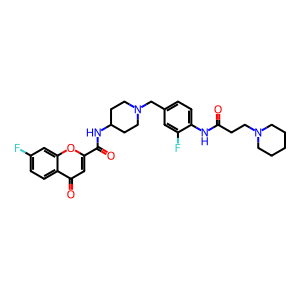

In [13]:
mols_rdchem = mols['ROMol']
# print a random molecule
sanity_check = mols_rdchem[np.random.randint(0, len(mols_rdchem))]
Draw.MolToImage(sanity_check)

In [14]:
def ClusterFps(fps,cutoff=0.2):
    from rdkit import DataStructs
    from rdkit.ML.Cluster import Butina

    # first generate the distance matrix:
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])

    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs


In [15]:
# Generate Morgan fingerprints
fps = [AllChem.GetMorganFingerprintAsBitVect(m,2,1024) for m in mols_rdchem]
# the patrameter 2 is the radius of the fingerprint and 1024 is the length of the bit vector. We chose 1024 because it is a common length for fingerprints; it is the length of the bit vector that is generated.

In [23]:
# Cluster the fingerprints
clusters = ClusterFps(fps,cutoff=0.4)
# Let's see how many clusters we have
len(clusters)

367

In [27]:
pics = []
for cluster in clusters[:5]:
    pics.append([Draw.MolToImage(mols_rdchem[x]) for x in cluster])
    print(len(cluster))
    for molecule in cluster:
        # turn the molecule into a mol object
        mol = mols_rdchem[molecule]

80
69
58
33
52


In [30]:
pics[0][0]
# export the images of each sublist (cluster) to a file
for i, cluster in enumerate(pics):
    for j, molecule in enumerate(cluster):
        molecule.save(f'../Data/clusters/cluster_{i}_molecule_{j}.png')

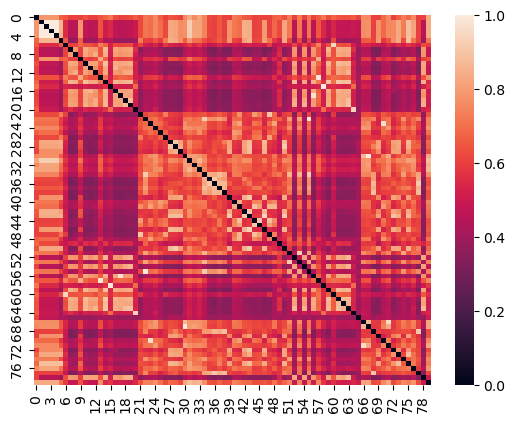

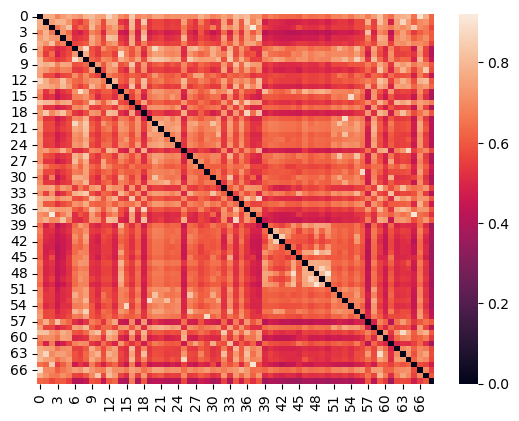

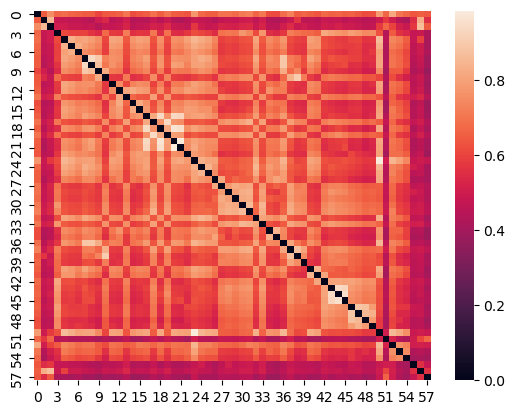

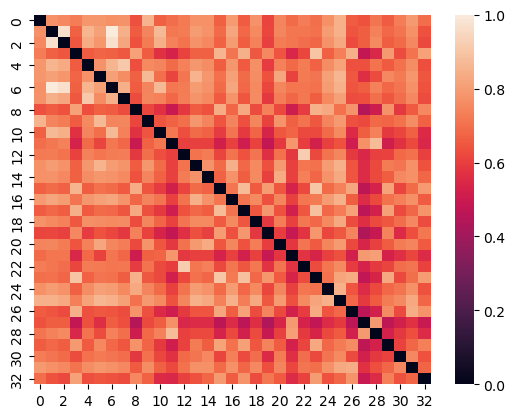

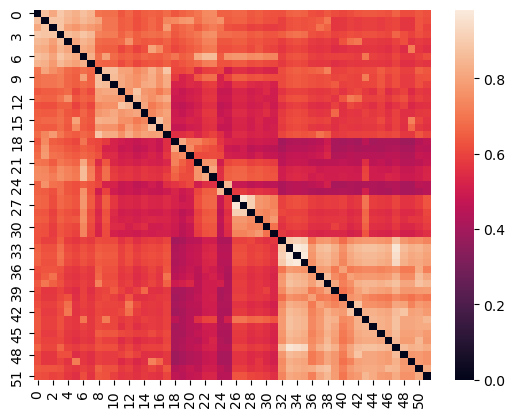

In [33]:
# evaluate the clusters: examine how similar the molecules in each cluster are, by calculating the Tanimoto similarity between each pair of molecules in a cluster
from rdkit import DataStructs
from rdkit.ML.Cluster import ClusterVis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
for cluster in clusters[:5]:
    # calculate the Tanimoto similarity between each pair of molecules in the cluster
    sims = np.zeros((len(cluster),len(cluster)))
    for i in range(len(cluster)):
        for j in range(i+1,len(cluster)):
            sims[i,j] = DataStructs.TanimotoSimilarity(fps[cluster[i]],fps[cluster[j]])
            sims[j,i] = sims[i,j]
    # plot the similarity matrix
    sns.heatmap(sims,annot=False)
    plt.show()
    avg_sim = np.mean(sims)

In [ ]:
def find_cluster(molecule, clusters):
    """find if the cluster that molecule belongs to, and retusn the cluster"""
    for cluster in clusters:
        if molecule in cluster:
            return cluster


In [44]:
from rdkit.Chem import Descriptors
def similarity_by_chem_params(cluster, mols_rdchem):
    """calculate the similarity between the molecules in a cluster based on their chemical parameters"""
    # calculate the similarity between each pair of molecules in the cluster
    sims = np.zeros((len(cluster),len(cluster)))
    for i in range(len(cluster)):
        for j in range(i+1,len(cluster)):
            # calculate the similarity between the molecules based on their chemical parameters
            # first, calculate the chemical parameters for each molecule by turning them from fingerprints to mol objects
            mol1 = mols_rdchem[cluster[i]]
            mol2 = mols_rdchem[cluster[j]]
            # calculate the similarity between the molecules based on their chemical parameters line number of atoms, molecular weight, number of hydrogen bond donors, number of hydrogen bond acceptors, and logP
            sim_dict = {'num_atoms': [Descriptors.HeavyAtomCount(mol1), Descriptors.HeavyAtomCount(mol2)],
                        'mol_weight': [Descriptors.MolWt(mol1), Descriptors.MolWt(mol2)],
                        'num_hbd': [Descriptors.NumHDonors(mol1), Descriptors.NumHDonors(mol2)],
                        'num_hba': [Descriptors.NumHAcceptors(mol1), Descriptors.NumHAcceptors(mol2)],
                        'logp': [Descriptors.MolLogP(mol1), Descriptors.MolLogP(mol2)]}
            # calculate the similarity between the molecules based on their chemical parameters
            sim = 1 - np.linalg.norm(list(sim_dict.values()))/np.linalg.norm(list(sim_dict.values())[0])
            sims[i,j] = sim
            sims[j,i] = sim

    # plot the similarity matrix
    sns.heatmap(sims,annot=False)
    plt.show()
    avg_sim = np.mean(sims)
    return avg_sim

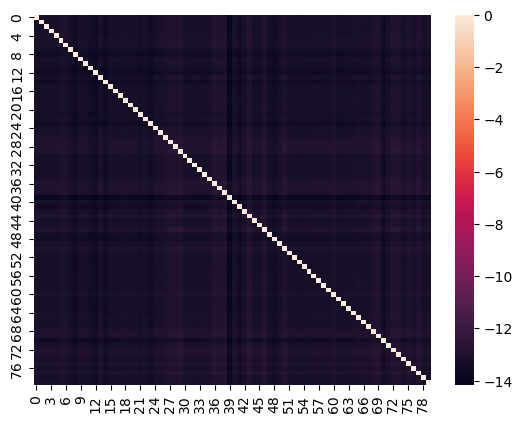

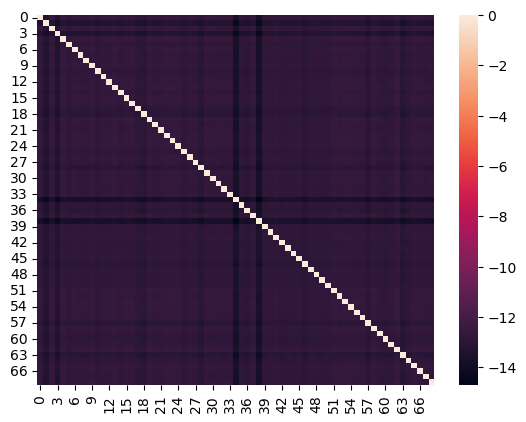

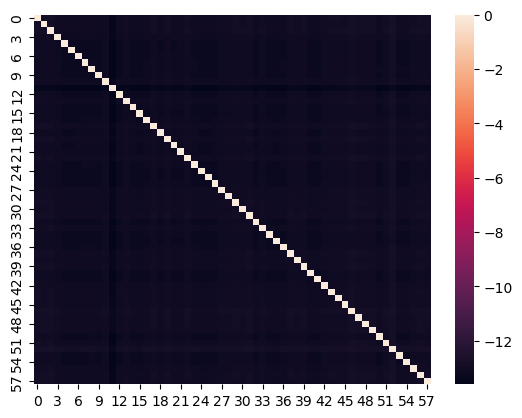

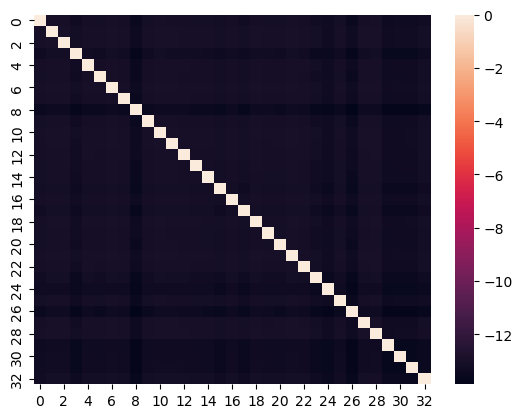

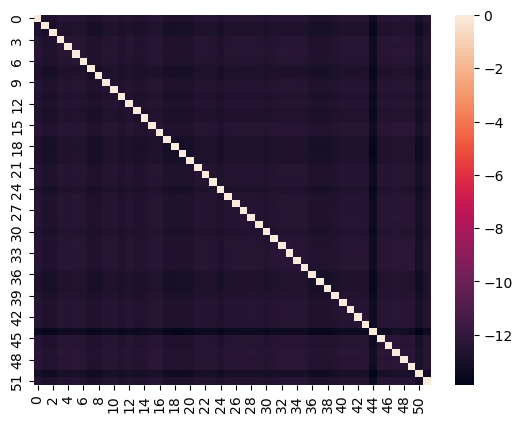

In [45]:
# calculate the similarity between the molecules in each cluster based on their chemical parameters
for cluster in clusters[:5]:
    similarity_by_chem_params(cluster, mols_rdchem)
